In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Import

In [2]:
import pandas
import numpy
from sklearn.metrics import roc_curve, roc_auc_score

## Reading initial data

In [3]:
import root_numpy
data_full = pandas.DataFrame(root_numpy.root2array('datasets/tracks.root', 'tracks', 
                                                  branches=['run', 'event', 'N_sig_sw', 'signB', 'signTrack', 'IPs',
                                                           'diff_eta', 'diff_phi']))

In [4]:
data_full.head()

,run,event,N_sig_sw,signB,signTrack,IPs,diff_eta,diff_phi
0,115839,204997902,0.59521,1,-1,0.816143,0.201112,-0.136253
1,115839,204997902,0.59521,1,-1,1.375382,0.684863,-0.072971
2,115839,204997902,0.59521,1,-1,4.338812,0.749864,-4.177158
3,115839,204997902,0.59521,1,1,2.287509,-0.644510,-0.599056
4,115839,204997902,0.59521,1,1,0.562424,0.736161,-3.499841


In [5]:
event_id_column = 'event_id'
event_id = data_full.run.apply(str) + '_' + data_full.event.apply(str)
data_full[event_id_column] = event_id

## Remove rows with NAN from data

In [8]:
data_full = data_full.dropna()
len(data_full)

27156190

## Tagging track sign independence checking

In [9]:
import utils

### assign $p(B+) = -\sum signTrack_i$

### assign $p(B+) = -\sum signTrack_i - signB$

In [28]:
def compute_sum_of_charges(data, name, bins=60):
    result_event_id, event_positions, data_ids = numpy.unique(data[event_id_column].values, return_index=True, return_inverse=True)
    result_probs = -numpy.bincount(data_ids, weights=data.signTrack.values)
    result_label = numpy.bincount(data_ids, weights=data.signB.values) / numpy.bincount(data_ids)
    result_weight = numpy.bincount(data_ids, weights=data.N_sig_sw.values) / numpy.bincount(data_ids)
    
    min_max = 10
    result = {} 
    result['ROC $-\sum_i charge_i$'] = [roc_auc_score(result_label, result_probs, sample_weight=result_weight)]

    figure(figsize=(16, 7))
    subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(result_label, result_probs, sample_weight=result_weight)
    plot(fpr, tpr)
    plot([0, 1], [0, 1], 'k--')
    grid(True), xlim(0, 1), ylim(0, 1), title('ROC $-\sum_i charge_i$')
    subplot(1, 2, 2)
    
    hist(result_probs * (result_label == 1), bins=bins, weights=result_weight * (result_label == 1), 
         range=(-min_max, min_max), alpha=0.2, normed=True, label='$B^+$')
    hist(result_probs * (result_label == -1), bins=bins, weights=result_weight * (result_label == -1), 
         range=(-min_max, min_max), alpha=0.2, normed=True, label='$B^-$')
    legend(), title(name + ', $-\sum_i charge_i$'), xlim(-min_max, min_max)
    
    plt.savefig('img/assymetry_tracks_{}.png'.format(name), format='png')
    
    show()
    
    figure(figsize=(16, 7))
    subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(result_label, result_probs - result_label, sample_weight=result_weight)
    plot(fpr, tpr)
    plot([0, 1], [0, 1], 'k--')
    grid(True), xlim(0, 1), ylim(0, 1), title('ROC $-\sum_i charge_i$ - signal track sign')
    subplot(1, 2, 2)
    
    hist((result_probs - result_label) * (result_label == 1), bins=bins, weights=result_weight * (result_label == 1), 
         range=(-min_max, min_max), alpha=0.2, normed=True, label='$B^+$')
    hist((result_probs - result_label) * (result_label == -1), bins=bins, weights=result_weight * (result_label == -1), 
         range=(-min_max, min_max), alpha=0.2, normed=True, label='$B^-$')
    legend(), title(name + ', $-\sum_i charge_i$ - signal track sign'), xlim(-min_max, min_max)

    plt.savefig('img/assymetry_tracks_with_sig_part_{}.png'.format(name), format='png')
    
    show()
    
    result = {}
    for mask, bname in zip([result_label == 1, result_label == -1], ['$B^+$', '$B^-$']):
        result[bname] = [numpy.sum(result_probs * result_weight * mask) / sum(result_weight * mask)]
        result[bname + ', with signal part'] = [numpy.sum((result_probs - result_label) * \
                                                         result_weight * mask) / sum(result_weight * mask)]
    result['ROC AUC'] = roc_auc_score(result_label, result_probs, sample_weight=result_weight)
    result['ROC AUC, with signal part'] = 1 - roc_auc_score(result_label, result_probs - result_label, 
                                                            sample_weight=result_weight)
    result['name'] = [name]
    return pandas.DataFrame(result)

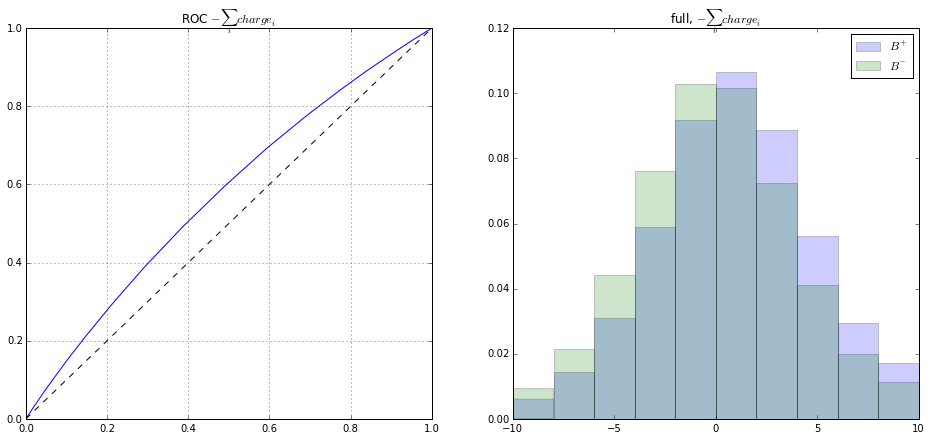

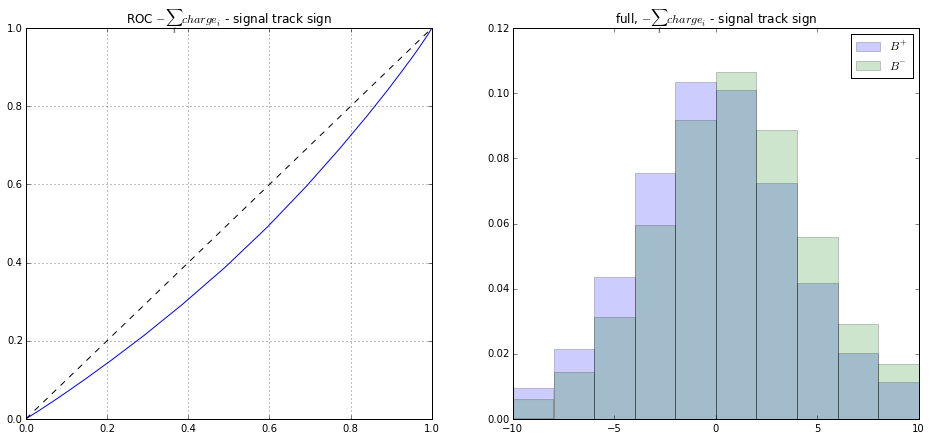

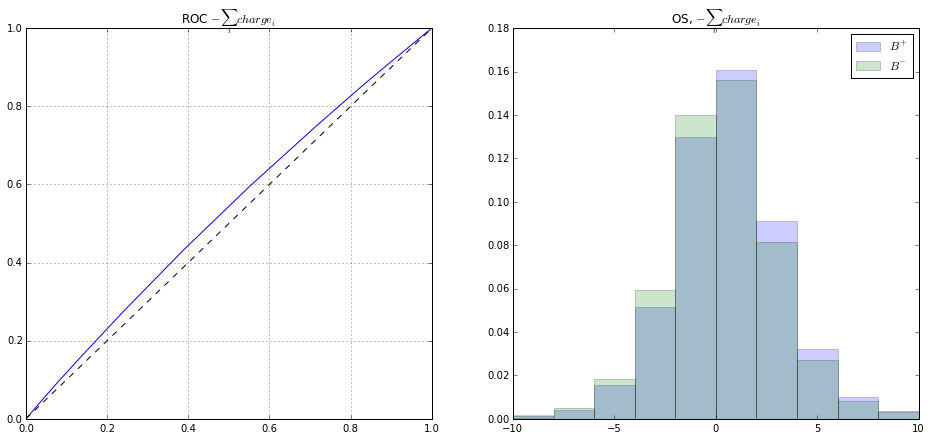

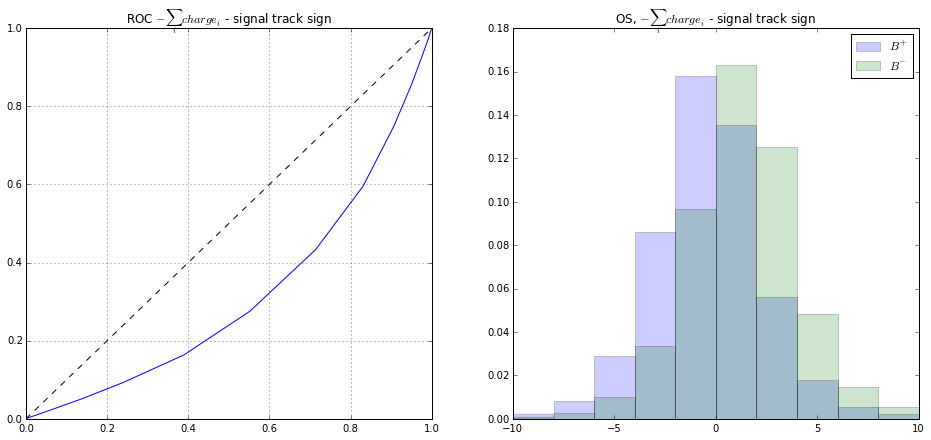

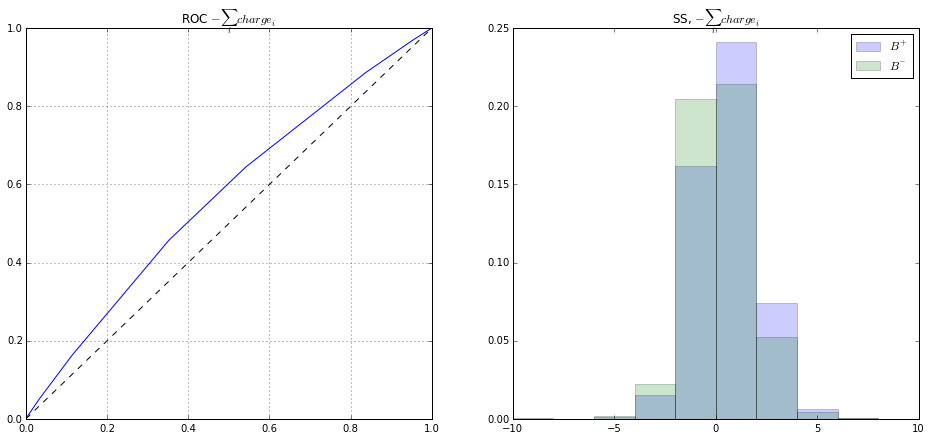

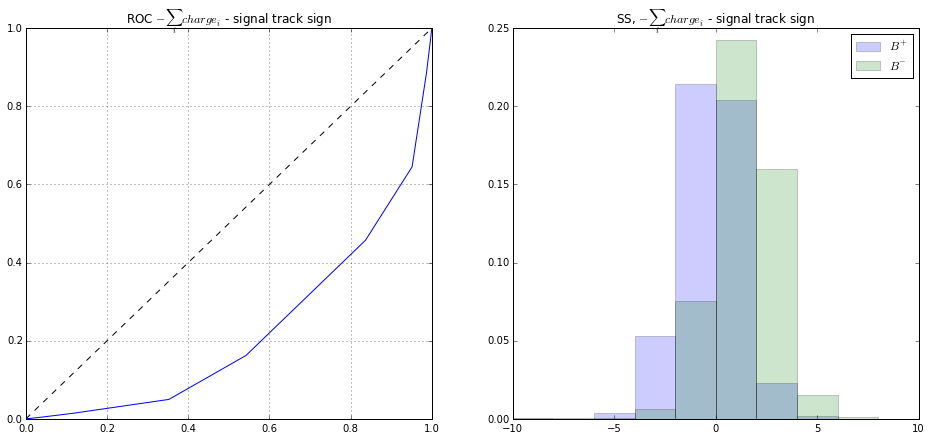

In [29]:
means = [compute_sum_of_charges(data_full[mask], name, bins) for mask, name, bins in \
         zip([data_full.signB > -100, 
              (data_full.IPs > 3) * ((abs(data_full.diff_eta) > 0.6) | (abs(data_full.diff_phi) > 0.825)), 
              (abs(data_full.diff_eta) < 0.6) & (abs(data_full.diff_phi) < 0.825) * (data_full.IPs < 3)], 
             ['full', 'OS', 'SS'], [10, 10, 10])]

In [30]:
means = pandas.concat(means)

In [31]:
means

,$B^+$,"$B^+$, with signal part",$B^-$,"$B^-$, with signal part",ROC AUC,"ROC AUC, with signal part",name
0,0.443411,-0.556589,-0.572163,0.427837,0.571579,0.569146,full
0,0.111173,-0.888827,-0.157273,0.842727,0.529527,0.684603,OS
0,0.175970,-0.824030,-0.178102,0.821898,0.567696,0.777694,SS


In [32]:
means.to_csv('img/track_signs_assymetry_means.csv', index=False, header=True)

## random track strategy for event

In [34]:
    result_event_id, event_positions, data_ids = numpy.unique(data_full[event_id_column].values, return_index=True, return_inverse=True)

In [35]:
data_ids # event indices
track_ids = numpy.arange(len(data_ids))
selected_ids = numpy.zeros(numpy.max(data_ids) + 1)
selected_ids[data_ids] = track_ids # assigns last track in each event
permutation = numpy.random.permutation(track_ids)
selected_ids[data_ids[permutation]] = track_ids[permutation]

In [36]:
len(data_full), max(selected_ids.astype(int))

(27156190, 27156186)

In [39]:
result_label = numpy.bincount(data_ids, weights=data_full.signB.values) / numpy.bincount(data_ids)
result_weight = numpy.bincount(data_ids, weights=data_full.N_sig_sw.values) / numpy.bincount(data_ids)

In [40]:
signs_random = data_full.signTrack.values[selected_ids.astype(int)]

In [41]:
roc_auc_score(result_label, signs_random)

0.48935024021414875

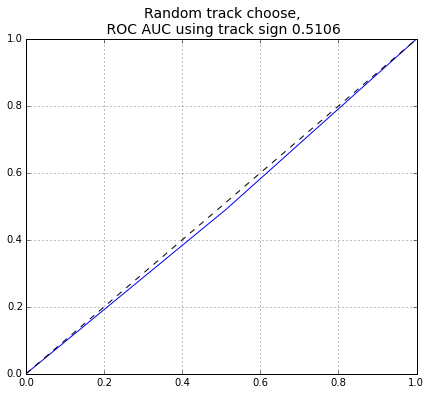

In [48]:
figsize(7, 6)
plot(*roc_curve(result_label, signs_random)[:2])
plot([0, 1], [0, 1], 'k--')
grid()
title('Random track choose, \n ROC AUC using track sign %1.4f' %(1 - roc_auc_score(result_label, signs_random)), fontsize=14)
plt.savefig('img/assymetry_tracks_random.png', format='png')